## Convolutional neural networks - classifying handwritten numbers

#### $\textbf{Goal}:$ Using the MNIST dataset, containing about 70000 28x28 black and white images of handwritten numbers, the goal of this exercise is to correctly classify these images using a CNN.

$\textbf{Background}:$ Convolutional Neural Networks (CNNs) are a specialized class of deep learning models designed to process and analyze visual data, making them ideal for image classification tasks. Unlike traditional neural networks, CNNs use a combination of convolutional layers, pooling layers, and fully connected layers to automatically learn hierarchical features from input images.

Convolutional Layers: These layers apply filters (also called kernels) that slide over the input image, capturing spatial hierarchies by detecting local patterns such as edges, textures, and corners. Each filter extracts specific features, which become more abstract in deeper layers. This operation reduces the image's dimensionality while preserving its important features.

Pooling Layers: After convolution, pooling layers reduce the spatial dimensions of the feature maps, which helps in minimizing computation and preventing overfitting. Max pooling is commonly used, which keeps only the most important features (maximum values) from each region.

Fully Connected Layers: Toward the end of the network, the extracted features are flattened and passed through fully connected layers, where every node is connected to every other node in the next layer. These layers perform the final classification based on the learned features.

![Image of Yaktocat](https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

***

Author: Simon Guldager

Date: October 11, 2024

In [276]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Keras documentation can be found on keras.io:
import keras
from keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

In [277]:
def plot_training_results(history):

    # make a list of the train and val metrics
    metrics = list(history.history.keys())
    
    # make lists of train and val metrics
    val_metrics = [entry for entry in metrics if entry.startswith('val_')]
    train_metrics = [entry for entry in metrics if not entry.startswith('val_')]

    # the number of metrics to plot
    Nmetrics = len(val_metrics)
    width = 5 * Nmetrics

    fig, ax = plt.subplots(ncols = Nmetrics, figsize=(width, 5))

    # plot the train and val results for each metric
    for i, axx in enumerate(ax):
        ax[i].plot(history.history[train_metrics[i]], label='train', alpha = 0.7)  
        ax[i].plot(history.history[val_metrics[i]], label='validation', alpha = 0.7)
        ax[i].set_ylabel(f'{train_metrics[i].replace("_"," ").capitalize()}')
        ax[i].set_xlabel('Epoch')
        ax[i].legend(loc='best')
    fig.tight_layout()
    return fig, ax 

## Data exploration

Load the MNIST dataset and split it into traning, validation and test data

In [279]:
# load the data, split between train and testval sets
(train_images, train_labels), (testval_images, testval_labels) = mnist.load_data()

# define image dimensions. img_channels = 1 for grayscale images
img_rows, img_cols, img_channels = train_images.shape[1], train_images.shape[2], 1

# split testval set into specific test and validation set
val_images, test_images, val_labels, test_labels = train_test_split(
    testval_images, testval_labels, test_size=0.2, random_state=42
    )

Let's have a look at the first 15 images

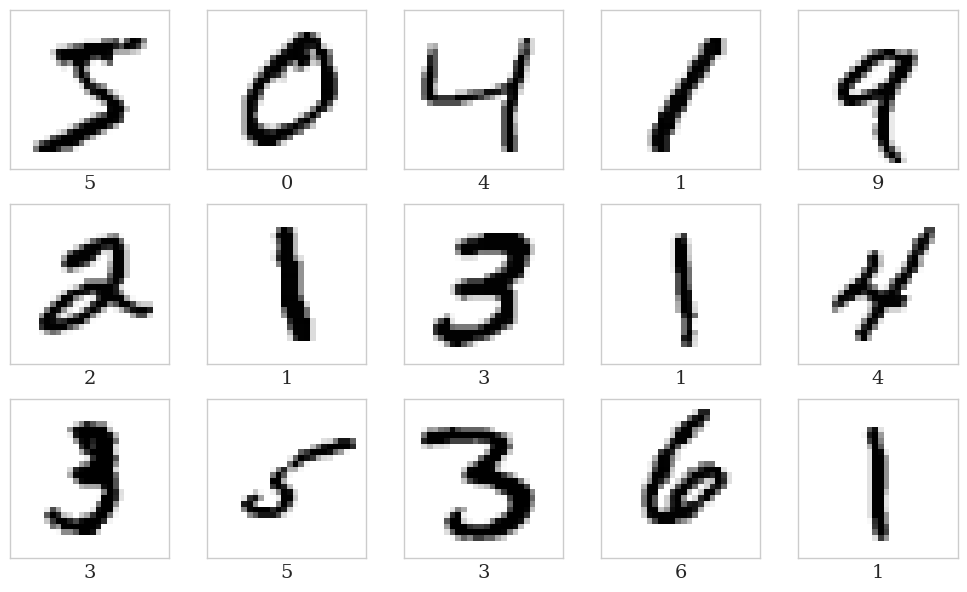

In [280]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
ax = ax.flatten()
for i in range(len(ax)):
    # Display an image
    ax[i].imshow(train_images[i], cmap=plt.cm.binary)
    ax[i].set(xlabel = (train_labels[i]), xticks = [], yticks = [])
    ax[i].grid(False)   
    
plt.tight_layout()

Each pixel can take a value between 0 and 255, the former being wite and the latter black. Let's plot the pixel distribution for all training images as a histogram

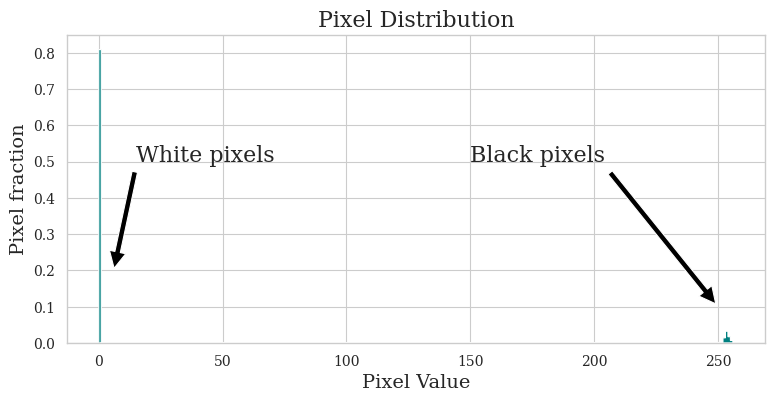

In [281]:
fig, ax = plt.subplots(figsize=(9,4))
ax.hist(train_images.flatten(), bins=256, range=(0,256), density=True, color='teal', histtype='stepfilled',);
ax.set(xlabel='Pixel Value', ylabel='Pixel fraction', title='Pixel Distribution')

# make arrow to show threshold
ax.annotate('White pixels', xy=(6, 0.2), xytext=(15, .5),
            arrowprops=dict(facecolor='black', shrink=0.02), fontsize=16
            )
ax.annotate('Black pixels', xy=(250, 0.1), xytext=(150, .5),
            arrowprops=dict(facecolor='black', shrink=0.02), fontsize=16
            );

In [282]:
# calculate fraction of white and black pixels
white_pixel_fraction = (train_images.flatten() < 5).sum()/len(train_images.flatten())
black_pixel_fraction = (train_images.flatten() > 250).sum()/len(train_images.flatten())
print(f"Fraction of black pixels: {black_pixel_fraction:.2f}")
print(f"Fraction of white pixels: {white_pixel_fraction:.2f}")

Fraction of black pixels: 0.07
Fraction of white pixels: 0.81


## Data preprocessing

Standardize and reshape images into the appropriate format

In [295]:
# load the data, split between train and testval sets
(train_images, train_labels), (testval_images, testval_labels) = mnist.load_data()

# define image dimensions. img_channels = 1 for grayscale images
img_rows, img_cols, img_channels = train_images.shape[1], train_images.shape[2], 1

# split testval set into specific test and validation set
val_images, test_images, val_labels, test_labels = train_test_split(
    testval_images, testval_labels, test_size=0.2, random_state=42
    )

# define function to standardize pixel values
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save mean and standard deviation of training data for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# standardize test data using training mean and standard deviation
# to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)

# adapt to format required by tensorflow, i.e. (n_samples, img_rows, img_cols, n_channels)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, img_channels)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)

# convert label vectors using one hot encoding
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# print shapes of training, validation and test sets
print("Training set image shapes:", train_images.shape)
print("Training set labels shapes:", train_labels.shape)
print("\nValidation set image shapes:", val_images.shape)
print("Validation set labels shapes:", val_labels.shape)
print("\nTest set image shapes:", test_images.shape)
print("Test set labels shapes:", test_labels.shape)


Training set image shapes: (60000, 28, 28, 1)
Training set labels shapes: (60000, 10)

Validation set image shapes: (8000, 28, 28, 1)
Validation set labels shapes: (8000, 10)

Test set image shapes: (2000, 28, 28, 1)
Test set labels shapes: (2000, 10)


## Building, training, evaluating and optimizing a CNN

Build model

... forklare ideen med parametrene i store træk.

In [300]:
model = Sequential()

model.add(Conv2D(filters=128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=8,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.05))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 14, 14, 8)         9224      
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 8)           0         
                                                                 
 flatten_23 (Flatten)        (None, 392)             

Compile and train model

In [301]:
# set the central parameters for compiling and training
learning_rate = 1e-5
epochs = 5
batch_size = 512

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['categorical_accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/5
118/118 [==============================] - 52s 430ms/step - loss: 2.2986 - categorical_accuracy: 0.1294 - val_loss: 2.2555 - val_categorical_accuracy: 0.1769
Epoch 2/5
118/118 [==============================] - 55s 467ms/step - loss: 2.2163 - categorical_accuracy: 0.2269 - val_loss: 2.1683 - val_categorical_accuracy: 0.3408
Epoch 3/5
118/118 [==============================] - 51s 431ms/step - loss: 2.1173 - categorical_accuracy: 0.3942 - val_loss: 2.0468 - val_categorical_accuracy: 0.5207
Epoch 4/5
118/118 [==============================] - 52s 444ms/step - loss: 1.9755 - categorical_accuracy: 0.5196 - val_loss: 1.8705 - val_categorical_accuracy: 0.6055
Epoch 5/5
118/118 [==============================] - 53s 452ms/step - loss: 1.7877 - categorical_accuracy: 0.5959 - val_loss: 1.6517 - val_categorical_accuracy: 0.6696


# Inspect learned kernels:

The kernels (also called filters or masks) are the (typically 3x3) matrices that are convoluted across the input image to produce output images, which are then concatenated. Inspecting them can (sometimes?) give an idea of what goes on (edge detection, sharpen, blurring, etc.) in the different layers, see [Wikipedia on Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing)).

1st 30 filters in convolution layer 1:


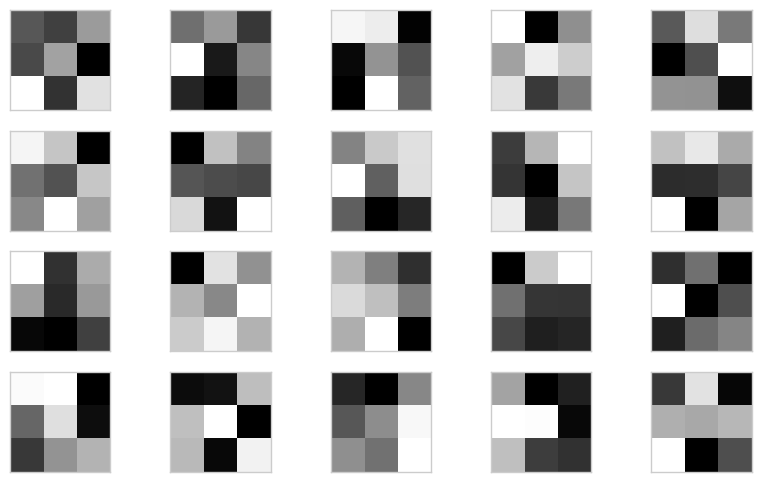

In [307]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

Nfilters_to_plot = 30

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print(f'1st {Nfilters_to_plot} filters in convolution layer 1:')
fig, ax = plt.subplots(4,5, figsize=(10, 6))
axs = ax.flatten()
for i in range(20):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Evaluate training process

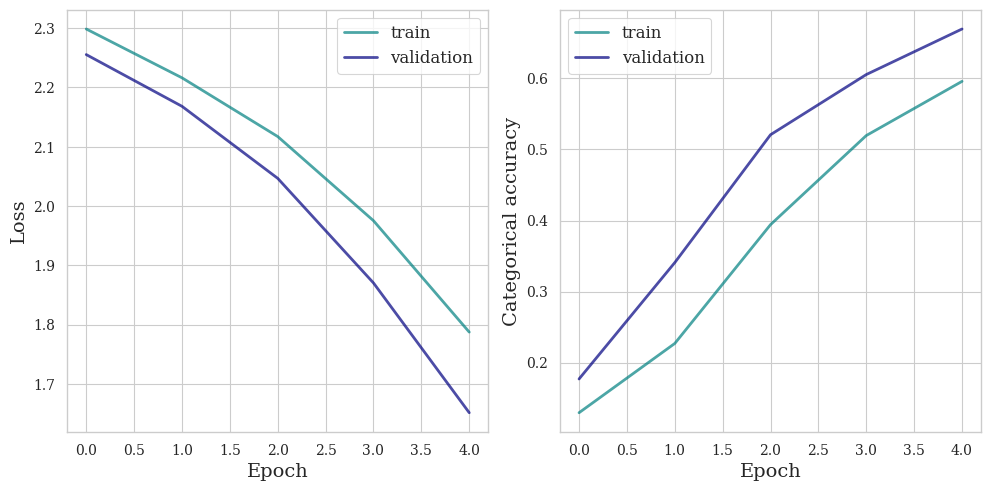

In [308]:
plot_training_results(history);

Evaluate your model on the validation data. 

In [309]:
# Predict on the validation set
val_prediction_probabilities = model.predict(val_images)
val_predictions = np.argmax(val_prediction_probabilities, axis=1)

# Calculate classification report
val_accuracy = accuracy_score(np.argmax(val_labels, axis = 1), val_predictions)
report = classification_report(np.argmax(val_labels, axis = 1), val_predictions)

print("\nClassification Report:\n", report)

250/250 [==============================] - 2s 8ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.94      0.66       777
           1       0.81      0.92      0.86       919
           2       0.72      0.68      0.70       819
           3       0.51      0.87      0.65       802
           4       0.70      0.59      0.64       767
           5       0.81      0.34      0.48       718
           6       0.76      0.62      0.68       758
           7       0.83      0.80      0.81       841
           8       0.86      0.11      0.19       788
           9       0.67      0.75      0.71       811

    accuracy                           0.67      8000
   macro avg       0.72      0.66      0.64      8000
weighted avg       0.72      0.67      0.64      8000



Calculate and plot confusion matrix

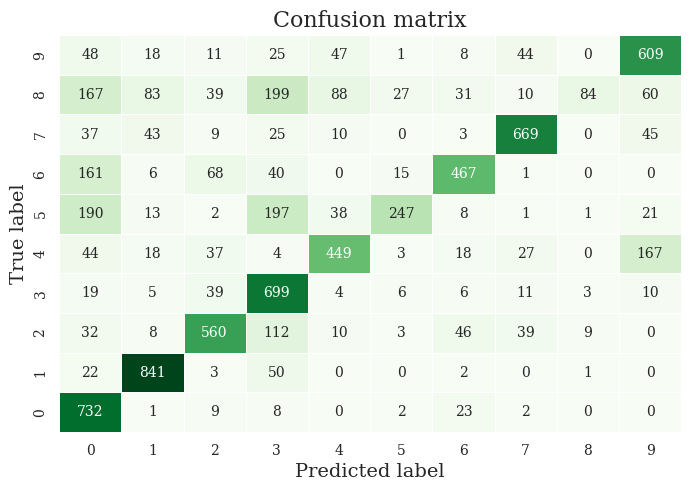

In [310]:
val_conf_matrix = confusion_matrix(y_true=np.argmax(val_labels, axis=1), y_pred=val_predictions)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(val_conf_matrix, ax=ax, annot=True, 
            annot_kws={"size": 10}, fmt="d", linewidths=.5, 
            cbar=False, cmap='Greens'
            )

ax.invert_yaxis()
ax.set(ylabel='True label', xlabel='Predicted label', title='Confusion matrix')
fig.tight_layout()

Inference: evaluating model performance on the unseen test data

In [226]:
# Predict on unseen test data
test_prediction_probabilities = model.predict(test_images)
test_predictions = np.argmax(test_prediction_probabilities, axis=1)

test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_predictions)
report = classification_report(np.argmax(test_labels, axis=1), test_predictions)
print("\nClassification Report:\n", report)


63/63 [==============================] - 0s 6ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.77       203
           1       0.95      0.44      0.61       216
           2       0.89      0.41      0.56       213
           3       0.69      0.64      0.67       208
           4       0.35      0.65      0.46       215
           5       0.33      0.29      0.31       174
           6       0.50      0.84      0.63       200
           7       0.39      0.87      0.54       187
           8       0.59      0.13      0.21       186
           9       0.43      0.02      0.03       198

    accuracy                           0.52      2000
   macro avg       0.58      0.52      0.48      2000
weighted avg       0.59      0.52      0.48      2000



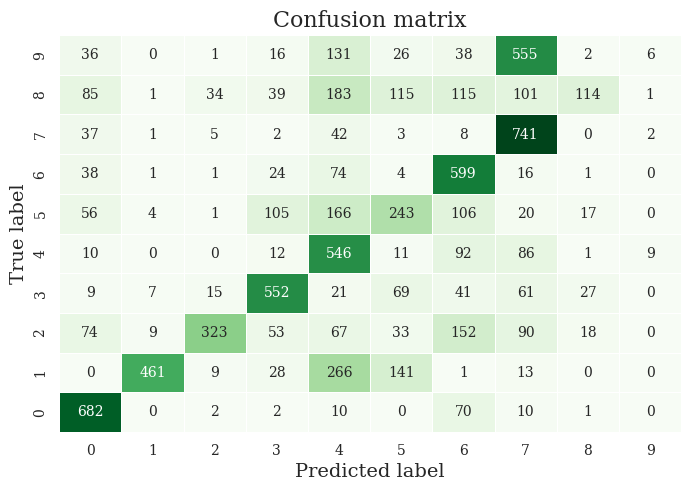

In [250]:
test_conf_matrix = confusion_matrix(y_true=np.argmax(test_labels, axis=1), y_pred=test_predictions)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(val_conf_matrix, ax=ax, annot=True, 
            annot_kws={"size": 10}, fmt="d", linewidths=.5, 
            cbar=False, cmap='Greens'
            )

ax.invert_yaxis()
ax.set(ylabel='True label', xlabel='Predicted label', title='Confusion matrix')
fig.tight_layout()

In [268]:
filters1.shape, filters2.shape, biases1.shape, biases2.shape

((3, 3, 1, 32), (3, 3, 32, 32), (32,), (32,))

# Inspection of predictions

### Correctly predicted images

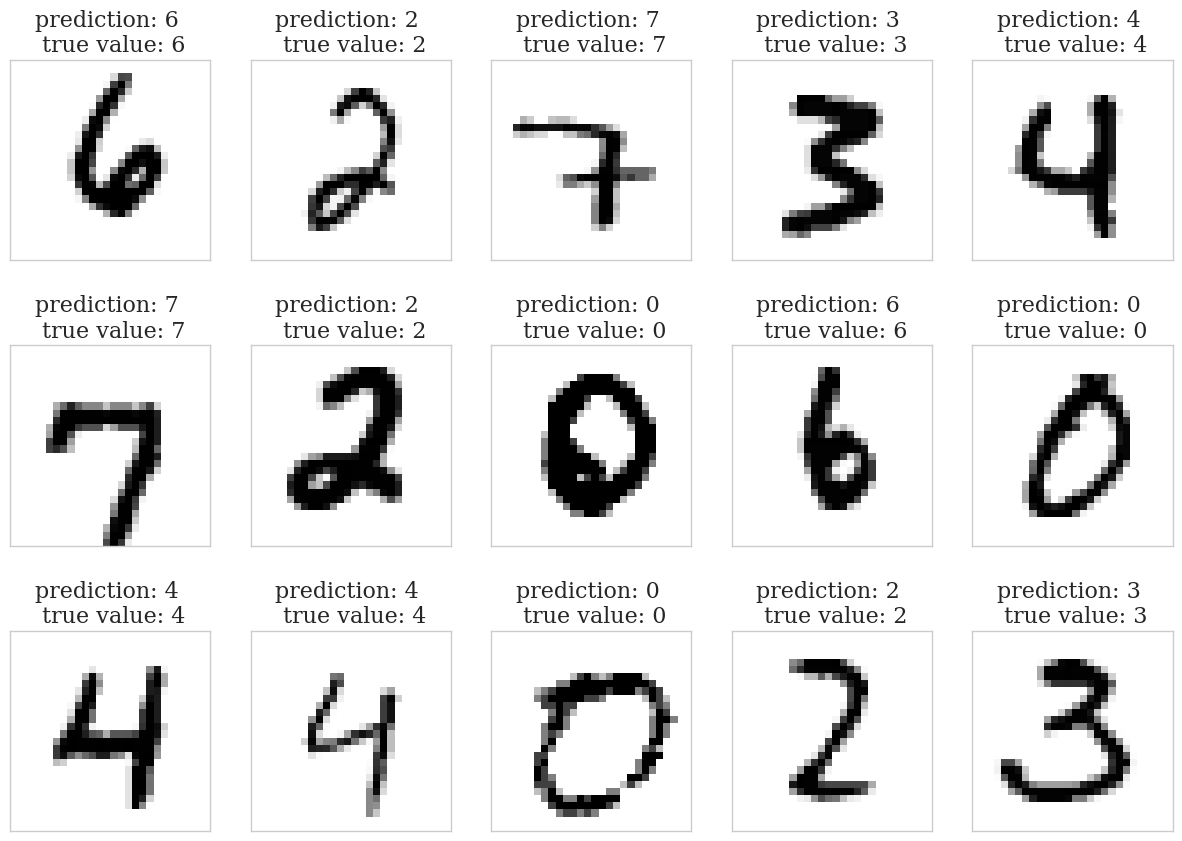

In [248]:
# show first Nimg images that were correctly predicted
Nimg = 15
correct_idx = np.where(test_predictions == np.argmax(test_labels, axis=1))[0]

nrows = int(np.ceil(Nimg/5))
fig, ax = plt.subplots(nrows,5, figsize=(15, 3.5*nrows))
ax = ax.flatten()   
for i in range(Nimg):
    ax[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    ax[i].set(title= f'prediction: {test_predictions[correct_idx[i]]} \n true value: {np.argmax(test_labels, axis=1)[correct_idx[i]]}',
              xticks = [], yticks = []
              )
    ax[i].grid(False)   

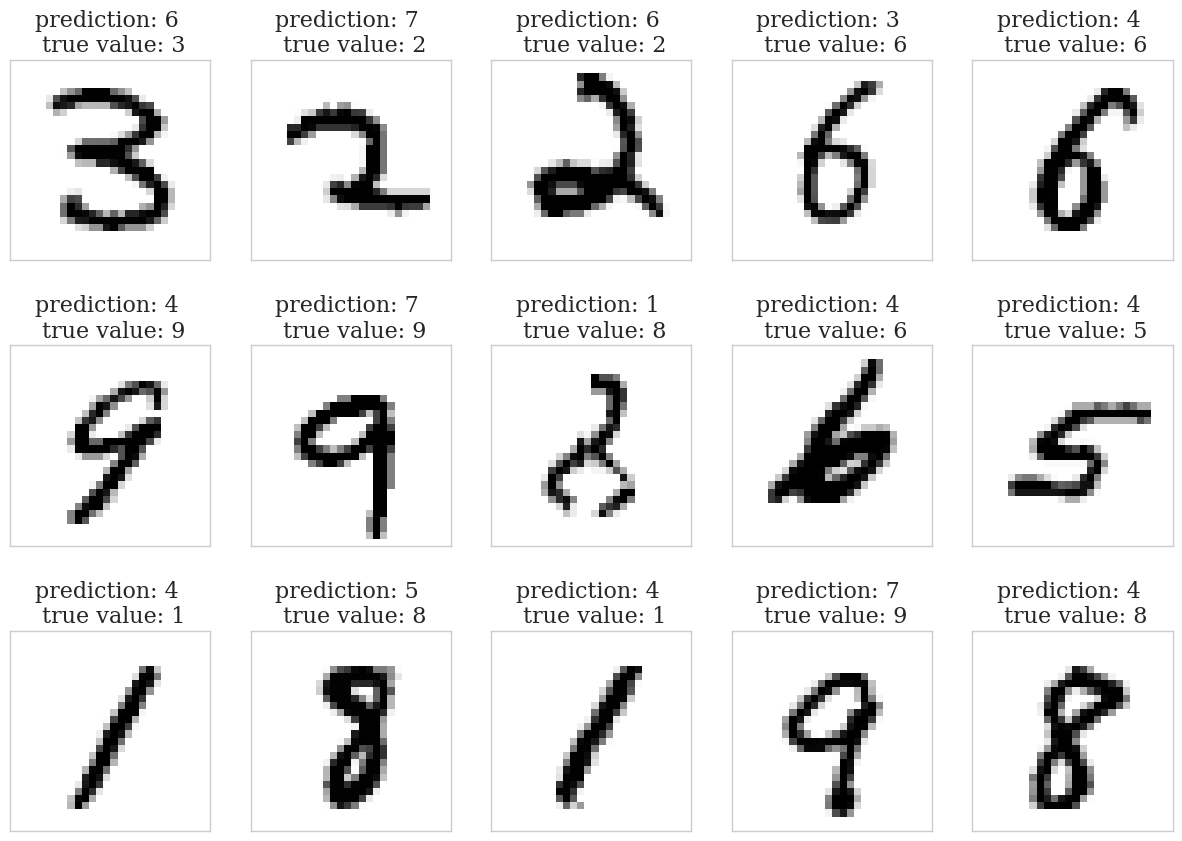

In [249]:
# show first Nimg images that were correctly predicted
Nimg = 15
correct_idx = np.where(test_predictions != np.argmax(test_labels, axis=1))[0]

nrows = int(np.ceil(Nimg/5))
fig, ax = plt.subplots(nrows,5, figsize=(15, 3.5*nrows))
ax = ax.flatten()   
for i in range(Nimg):
    ax[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    ax[i].set(title= f'prediction: {test_predictions[correct_idx[i]]} \n true value: {np.argmax(test_labels, axis=1)[correct_idx[i]]}',
              xticks = [], yticks = []
              )
    ax[i].grid(False)   

## Exercise Questions:

1. Read through the code, understand each part, and draw the current architecture of the CNN.
2. How many parameters does you CNN model have?
3. Remind yourself (and your peers?) why the validation loss might be lower than the training loss?
4. From the confusion matrix, what are the most likely mistakes made?
5. Try to change the network architecture and other hyper parameters to see, if you can get a better accuracy?
6. How large is the test set used? And what precision do you reach? Do you see any challenges with this?
7. Discuss the correctly but in particular the **wrongly predicted** images with your peers.<br>
   What might be the main reason for the wrong predictions, and can they be remedied?

## Learning points:

From this exercise - which is partly for illustration, but also great for "playing around" with CNNs - you should have learned the following:
1. CNNs are the goto model for image analysis.
2. They work by convoluting the input images with kernels that are trained to recognise certain features in the image (not unlike neurons in an ordinary NN).
2. Your CNN considerations should include:
     - Sample and image sizes (enough training and testing data?),
     - CNN architecture (size and number of kernels),
     - Batch size (optimising how fast you converge), and
     - if you need GPUs for the problem!
3. CNNs can be implemented in (Keras) TensorFlow (easiest) and PyTorch (harder but more versatile).

## Final remarks:

This reflects a very simple and crude CNN model. Since MNIST is a relatively straightforward dataset, using a "larger" (i.e. full scale) CNN model, you should expect even better results! **However, the real test is, if you can apply the above approach to another more complicated dataset**.

Also, as the size of the problem grows (larger images!!!), the use of GPUs becomes necessary. They are typically a factor 20-50 faster.